# Group 49 Project Proposal: User Knowledge

***

### Introduction

We chose the User Knowledge dataset, which gives the students’ knowledge level per user (very low, low, middle, or high) based on their study times and exam performances (given as decimals between 0 and 1). We will create a **classification**  model to predict knowledge level by taking into account the amount of time spent studying as well as the exam performances for each student. We are using classification because we are placing individuals into a finite number of categories (e.g. tall vs. short) as opposed to assigning continuous labels (e.g. height in centimetres), which would be more suited for a regression model. 

The question we will try to answer with our project:
**Given the amount of time spent studying and the exam score of the students, does the student have very low, low, middle, or high knowledge?**

We will use the training dataset to answer this question and we will test the accuracy of our model using the test data. The initial split was already conducted on the dataset file.

…

##### The Significance of Our Research
Research on how to improve knowledge levels of specific subjects is important to help inform instructors on the best way to inspire growth in students, as well as allow students to understand the benefits of good study habits and exams. Instructors can use this research to help them decide if they want to include exams for certain subjects as well as what type of study materials to provide. Students can use this research to ascertain the subjects to focus on and how much value to place on exams. The gap in this dataset is that we do not know which subject(s) these scores are from. Knowledge level may vary with different learning strategies and exam scores across different subjects and even instructor (some instructors may create exams that promote more conceptual learning as opposed to rote memorisation). Since we do not have a large dataset with many differentiated subjects and their associated exam / teaching styles, we cannot address this gap.

# We also might need to mention something about why we intuitively decided to do Knn model and why we went with classification. Perhaps also discussing that intuitively it, it is likely that we will use the exam performance as logically that is usually used as the best indicator of "Knowledge level", as this is what usually makes up the large majority of our marks in University for example. However, we will analyze all variables first in order to avoid any bias and empirically determine if there are any patterns that suggest the best perdictors to utilize for our model. This is just my ramblings, if someone can give it more thought and flush it out, that would be great ~Zee. 

***



### Preliminary Exploratory Data Analysis

#### Loading Libraries
Loading all libraries that might be required at some point later on in the analysis. 

In [1]:
library(readxl)  #for excel sheet read system
library(DBI)  #for Reading Data from SQLite database
library(dbplyr)  #SQL Database queries functions
library(RSQLite)  #RSQL Database queries functions
library(RPostgres) # RPostgres Database functions
library(tidyverse)  #most of our tidyverse functions 
library(scales)  #for labeling comma function and log scales
library(RColorBrewer)  #color palette (includes color-blind options)
library(repr)  #ggplot visualization + options(repr.plot.width=8, repr.plot.height=7)
library(rsample) #create different types of resamples and corresponding classes for their analysis
library(tidymodels) #is a collection of packages for modeling and machine learning using tidyverse principles

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::ident()  masks dbplyr::ident()
✖ dplyr::lag()    masks stats::lag()
✖ dplyr::sql()    masks dbplyr::sql()


Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor


── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ recipes      1.0.1
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0

── Conflicts ────────────────────────────────────────

#### Reading the dataset into R 
To read the training dataset into R, we used the read_csv function and selected the relevant columns to minimise any unnecessary data being run. This was repeated for the testing dataset. 

We then use the mutate function to change the UNS column data type to factor instead of character, since each individual is sorted into one of four categories and the column is required to be a factor for knn classification as it needs to act as a categorical statistical variable in our knn classification.

In the code below, we delete the first row of data because it contains all zeroes because it interferes with cross-validation later. We can omit rows with only zeroes since they are likely incorrect data (we can expect none of the students that stayed in the course would spend no time studying and get 0 on exams too, and if they did, they would be an outlier).


In [74]:
training_data <- read_csv("knowledge_training_data.csv") |>
    select("STG", "STR", "SCG", "LPR", "PEG", "UNS") |>    
    mutate(UNS = as_factor(UNS)) |>
    tail(-1)
    #replace(training_data$UNS == "very_low", "Very Low")

#training_data[training_data=="very_low"]<-as.factor("Very Low")

#training_data_f <- replace(training_data$entry2, training_data$entry2 == "very_low","Very Low")

#if (UNS == "very_low") { 
 #                       replace("very_low","Very Low") 
        #                }

#training_data["UNS"][training_data["UNS"] == "very_low"] <- "Very Low"


#training_data["UNS"][training_data["UNS"] == "very_low"] <- "Very Low"



testing_data <- read_csv("knowledge_testing_data.csv") |>
    select("STG", "STR", "SCG", "LPR", "PEG", "UNS") |>
    mutate(UNS = as_factor(UNS))

training_data

New names:
• `` -> `...7`
• `` -> `...8`
Rows: 258 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): UNS, Attribute Information:
dbl (5): STG, SCG, STR, LPR, PEG
lgl (2): ...7, ...8

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


ERROR: [1m[33mError[39m:[22m
[33m![39m Assigned data `as.factor("Very Low")` must be compatible with existing data.
[34mℹ[39m Error occurred for column `UNS`.
[31m✖[39m Can't convert from <factor<4ad8f>> to <factor<7bcea>> due to loss of generality.
[36m•[39m Locations: 1.


#### Cleaning and Wrangling into a Tidy Format
We believe this data is tidy because each variable forms a column, each observation forms a row, and each cell is a single measurement. The data was checked for any missing data (NA) and none are present. 

In [55]:
training_data

STG,STR,SCG,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.00,0.00,0.000,0.00,0.00,very_low
0.08,0.10,0.080,0.24,0.90,High
0.06,0.05,0.060,0.25,0.33,Low
0.10,0.15,0.100,0.65,0.30,Middle
0.08,0.08,0.080,0.98,0.24,Low
0.09,0.40,0.150,0.10,0.66,Middle
0.10,0.43,0.100,0.29,0.56,Middle
0.15,0.34,0.020,0.40,0.01,very_low
0.20,0.35,0.140,0.72,0.25,Low


In [3]:
sum(is.na(training_data))

[1] 0

#### Exploratory Data Analysis
We took a count of our training data into a table that groups the data by the UNS (user knowledge level) column and summarizes by counting how many students there are for each level (very_low, Low, Middle, High). Next, we visualised this data with a bar chart with user knowledge level on the x-axis and the student count on the y-axis.

UNS,n
<fct>,<int>
very_low,24
High,63
Low,83
Middle,88


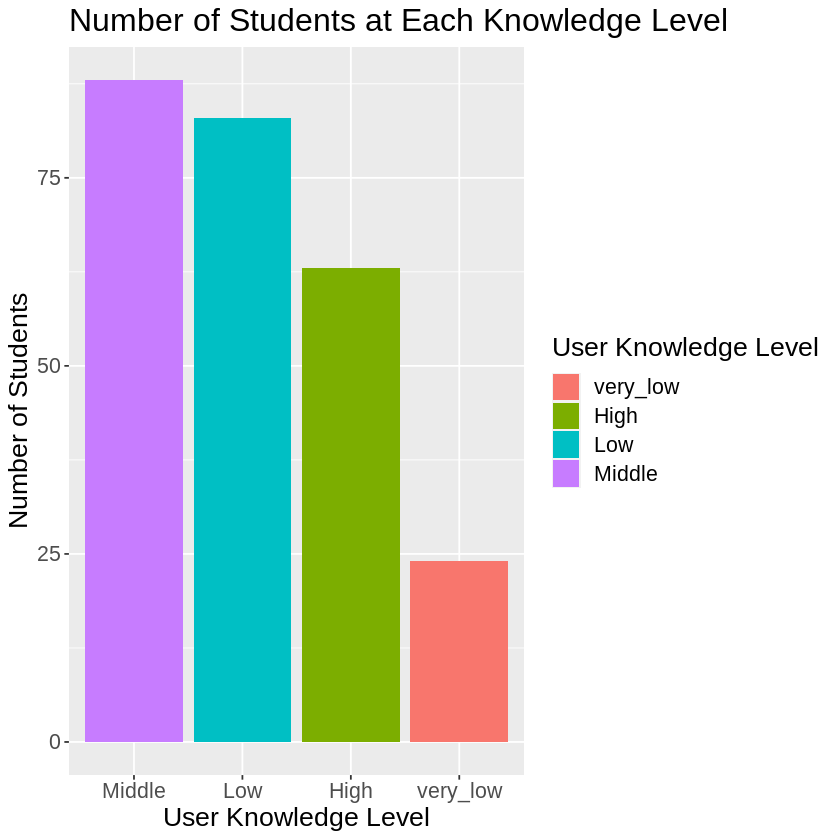

In [4]:
training_count <- training_data |>
                    group_by(UNS) |>
                    summarize(n = n())
              
training_count_bar <- training_count |>
        ggplot(aes(x = reorder(UNS, -n), y = n, fill = UNS)) +
        geom_bar(stat = "identity") +
        labs(x = "User Knowledge Level", y = "Number of Students", 
             fill = "User Knowledge Level", title = "Number of Students at Each Knowledge Level") +
        theme(text = element_text(size = 16))

training_count
training_count_bar

We decided to make an initial plot that was trying to understand the effects that studying and exam performance had on user knowledge level. Therefore, we took the average of studying time and exam performance of both direct and related objects respectively and then plotted it with colored points representing the knowledge level. The data showed some distinct clusters, although there appears to be significant overlap which might prove challenging for our classifier. 

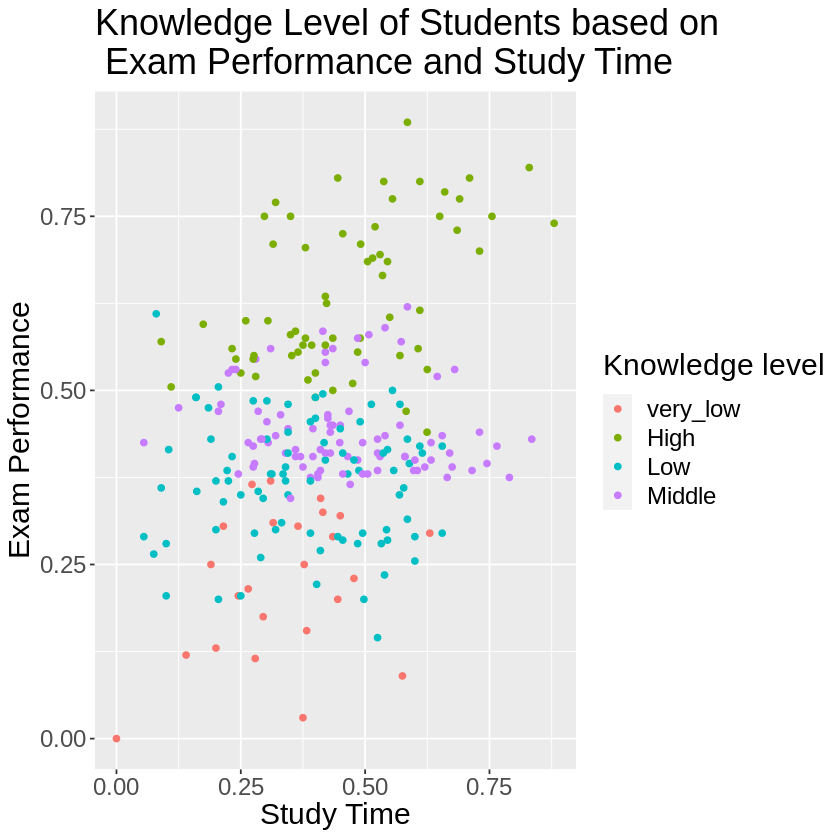

In [5]:
training_mutated <- training_data |>
    mutate(study_avg = ((STG + STR)/2)) |>
    mutate(exam_avg = ((LPR + PEG)/2))

training_avg_plot <- training_mutated |>
                ggplot(aes(x = study_avg, y = exam_avg, color = UNS)) +
                geom_point() +
                labs(x = "Study Time", y = "Exam Performance", color = "Knowledge level", 
                     title = "Knowledge Level of Students based on \n Exam Performance and Study Time") +
                theme(text = element_text(size=18))
training_avg_plot

The plots "Knowledge Level vs. Exam Performance" and "Knowledge Level vs. Average Degree of Study Time" below are used to visually gauge which aggregate variable (exam performance or study time) are more indicative of the knowledge level. Looking at the plots, exam performance looks to be the better indicator as the spread of the points are more precise and differentiated between knowledge levels with a stronger positive correlation as opposed to the weak positive correlation seen with study time.
# NEED TO TALK ABOUT THAT EXAM PERFORMANCE IS BETTER AND WE ARE GOING TO GO WITH THAT

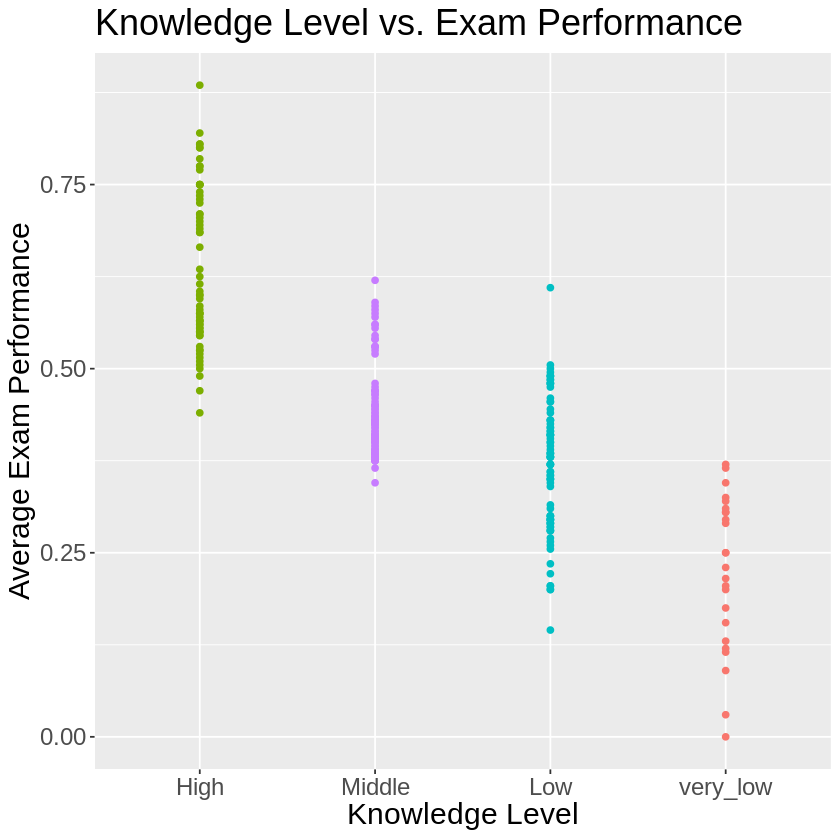

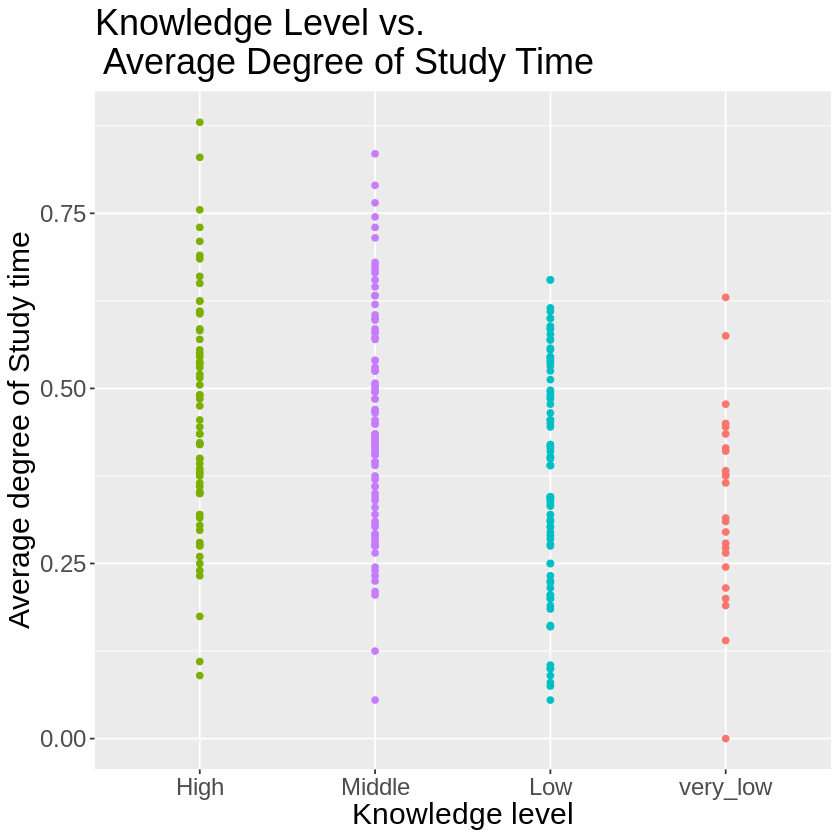

In [6]:
training_exam_avg_plot <- training_mutated |>
                ggplot(aes(x = reorder(UNS,-exam_avg), y = exam_avg, color = UNS)) +
                geom_point() +
                labs(x = "Knowledge Level", y = "Average Exam Performance",
                     title = "Knowledge Level vs. Exam Performance") +
                theme(text = element_text(size=18), legend.position = "none")

training_study_avg_plot <- training_mutated |>
                        ggplot(aes(x = reorder(UNS, -exam_avg), y = study_avg, color = UNS)) +
                        geom_point() +
                        labs(x = "Knowledge level", y = "Average degree of Study time", color = "Knowledge level", 
                             title = "Knowledge Level vs. \n Average Degree of Study Time") +
                        theme(text = element_text(size=18), legend.position = "none")

training_exam_avg_plot
training_study_avg_plot

***
### Methods

The data analysis method will follow the classification data flow and utilize the tidy models library to train, fit, and test our model in order to predict categorical observations for our question. The variables in this dataset categorise different studying strategies and exam performance, as well as repetition. We will be utilizing all except one of the variables listed below as they are relevant and applicable to developing a reasonable model that provides rigorous predictions for our question. The excluded variable is "degree of repetition number of user for goal object materials" because it is unclear what this is a measure of, even after looking at the available metadata.

* ##### The degree of study time for goal object materials (STG)
* ##### The degree of study time of user for related objects with goal object (STR) 
* ~~The degree of repetition number of user for goal object materials (SCG)~~ 
* ##### The exam performance of user for related objects with goal object (LPR)
* ##### The exam performance of user for goal objects (PEG)
* ##### The knowledge level of user (UNS)  

A method for visualizing the results will be to create a plot showing the observations of the test data similar to the plot "Knowledge Level of Students based on Exam Performance and Study Time", but one that will have background color behind it to show what our classifier would have predicted an observation at that location to be. This will be similar to Figure 5.15 found in the course textbook.   

## NEED TO CROSS OUT THE OTHER STUDY TIME STUFF, AND ONLY FOCUS ON THE EXAM PERFORMANCE. MAYBE EXPLAIN WHY

***

### Expected Outcomes and Significance  

We expect to find better user knowledge for students with greater study times and higher exam performances. We are predicting that more time spent on a subject usually means better knowledge, but higher exam scores may be a better predictor of knowledge level. This is because it is possible to have poor knowledge of a subject even after spending a lot of time studying it if the individual has an ineffective study strategy, whereas it is necessary to have good knowledge of the subject to get a high score on the exam. 
If our prediction is correct, findings may encourage students to find more efficient ways to study as opposed to just spending a lot of time using ineffective study strategies.

Future questions could be: 
* What is the most effective method of studying to consistently yield high exam scores?
* What is the most effective method of studying for individuals to retain information long-term?

***

# New Code. FEEL FREE TO REORDER STUFF HOWEVER MAKES SENSE !!!!! 

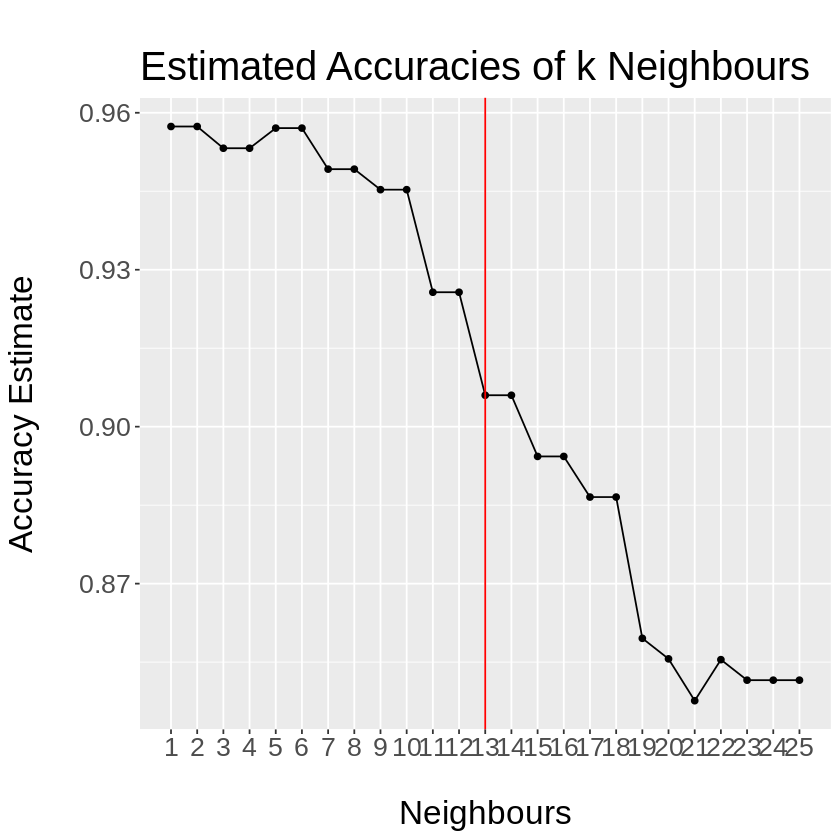

In [75]:
##NEED TO SET SEED AT THE BEGINNING OF WHOLE PROJECT !!!!
set.seed(1)

## RECIPE MAKE IT AND SCALING/ CENTERING ACCORDINGLY, DO WE NEED TO CONSIDER UPSAMPLING??? 
uk_recipe <- recipe(UNS ~LPR + PEG, data = training_data) |>
            step_scale(all_predictors()) |>
            step_center(all_predictors())

##KKNN SPEC
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")

#CREATING THE FOLDS AND GRID VALS
uk_fold <- vfold_cv(training_data, v = 5, strata = UNS)
gridvals <- tibble(neighbors = seq(1,25))

#WORKFLOW
uk_workflow <- workflow() |>
                add_recipe(uk_recipe) |>
                add_model(knn_spec) |>
                tune_grid(resamples = uk_fold, grid = gridvals) |>
                collect_metrics() |>
                filter(.metric == "accuracy")

#cross val grid NEEED TO FIX THIS STUFF AS WELLLLLLL
cross_val_plot <- uk_workflow |>
                    ggplot(aes(x= neighbors, y =mean)) +
                    geom_point() +
                    geom_line() +
                    geom_vline(xintercept = 13, colour = "red") +
                    #geom_point(aes(x = 13, y = ky), size = 4, colour = "blue") +
                    labs(x = "\nNeighbours", y = "Accuracy Estimate\n", title = "\nEstimated Accuracies of k Neighbours") +
                    scale_x_continuous(limits = c(1, 25), breaks = seq(1, 25), minor_breaks = seq(1, 25, 1)) +
                    theme(text = element_text(size = 20), plot.caption = element_text(size = 20, hjust = 0))

## FROM THE PLOT, THE BEST K VALUE WAS 6 as its surroundings were stable!!!!! Discuss more in detail in writeup
cross_val_plot

In [17]:
## BEST KNN SPEC 
knn_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 6) |>
  set_engine("kknn") |>
  set_mode("classification")

uk_fit <- workflow() |>
  add_recipe(uk_recipe) |>
  add_model(knn_best_spec) |>
  fit(data = training_data)


# Get the prediction column
uk_predictions <- predict(uk_fit, testing_data) |> 
    bind_cols(testing_data)

# Compare the accuracy of predictions to the true values in the test set
uk_acc <- uk_predictions |> 
    metrics(truth = UNS, estimate = .pred_class) |> 
    select(.metric, .estimate) |> 
    head(1)

# Compare the predictions to the true values in a confusion matrix
#uk_cm <- uk_predictions |> 
    #conf_mat(truth = UNS, estimate = .pred_class)

uk_predictions

ERROR: [1m[33mError[39m in [1m[1m`value[[3L]]()`:[22m
[33m![39m In metric: `accuracy`
[1m[22mProblem while computing `.estimate = metric_fn(truth = UNS, estimate =
.pred_class, na_rm = na_rm)`.
[1mCaused by error in [1m[1m`multiclass_checks()`:[22m
[33m![39m `truth` and `estimate` levels must be equivalent.
`truth`: Very Low, Low, High, Middle
`estimate`: very_low, High, Low, Middle


### References
Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.